In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,KFold,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report,accuracy_score,roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/hotel_reservations.csv')

print(f'Number of rows {df.shape[0]} and Number of cols {df.shape[1]}')

Number of rows 36275 and Number of cols 19


In [3]:
df.head(3)

,booking_id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled


In [4]:
df.drop(columns=['booking_id','arrival_year','arrival_month','arrival_date'],axis=1,inplace=True)
df.shape

(36275, 15)

<Axes: xlabel='count', ylabel='booking_status'>

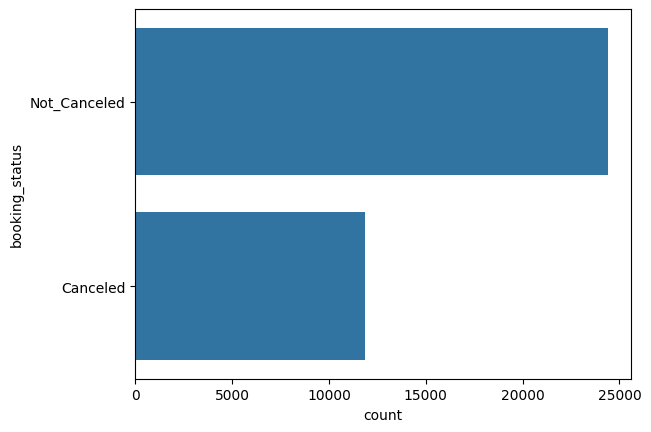

In [5]:
sns.countplot(df['booking_status'])

<Axes: xlabel='lead_time'>

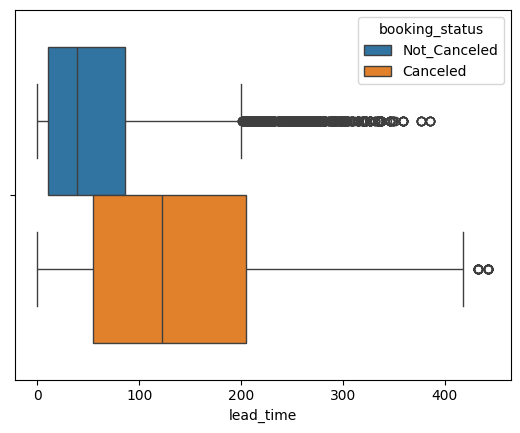

In [8]:
sns.boxplot(df,x='lead_time',hue='booking_status')

In [ ]:
# df_encoder = pd.get_dummies(df,columns=['type_of_meal_plan','room_type_reserved','market_segment_type'],drop_first=True,dtype=int)
# df_encoder.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,type_of_meal_plan_Meal Plan 2,type_of_meal_plan_Meal Plan 3,type_of_meal_plan_Not Selected,room_type_reserved_Room_Type 2,room_type_reserved_Room_Type 3,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online
0,2,0,1,2,0,224,0,0,0,65.00,0,Not_Canceled,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2,0,2,3,0,5,0,0,0,106.68,1,Not_Canceled,0,0,1,0,0,0,0,0,0,0,0,0,1
2,1,0,2,1,0,1,0,0,0,60.00,0,Canceled,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2,0,0,2,0,211,0,0,0,100.00,0,Canceled,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2,0,1,1,0,48,0,0,0,94.50,0,Canceled,0,0,1,0,0,0,0,0,0,0,0,0,1


In [10]:
x = df.drop('booking_status',axis=1)
y = df['booking_status']

In [13]:
num_feature = x.select_dtypes(exclude='object').columns
cat_feature = x.select_dtypes(include='object').columns

transfor = ColumnTransformer(
    [
        ('encoder',OneHotEncoder(dtype=int,drop='first'),cat_feature),
        ('scale',StandardScaler(),num_feature)
    ]
    
)

transfor

ColumnTransformer(transformers=[('encoder',
                                 OneHotEncoder(drop='first',
                                               dtype=<class 'int'>),
                                 Index(['type_of_meal_plan', 'room_type_reserved', 'market_segment_type'], dtype='object')),
                                ('scale', StandardScaler(),
                                 Index(['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'required_car_parking_space', 'lead_time',
       'repeated_guest', 'no_of_previous_cancellations',
       'no_of_previous_bookings_not_canceled', 'avg_price_per_room',
       'no_of_special_requests'],
      dtype='object'))])

In [14]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

x_train = transfor.fit_transform(x_train)
x_test = transfor.transform(x_test)

In [15]:
model_perams = {
    'LogisticRegression':{
        'model':LogisticRegression(),
        'params':{
            'C':[1,5,10,15],
            'solver':['lbfgs','liblinear']
        }
    },
    'DecisionTreeClassifier':{
        'model':DecisionTreeClassifier(),
        'params':{
            'criterion':['gini','entropy'],
            'max_depth':[1,5,10,15],
            'max_features':[1,2,4,'sqrt']
        }
    },
    
}

score =[]

for key,val in model_perams.items():
    clf = GridSearchCV(val['model'],val['params'],cv=3,return_train_score=False)
    clf.fit(x_train,y_train)
    score.append({
        'model':key,
        'best_params':clf.best_params_,
        'best_score':clf.best_score_
    })

pd.DataFrame(score)

,model,best_params,best_score
0,LogisticRegression,"{'C': 15, 'solver': 'lbfgs'}",0.802343
1,DecisionTreeClassifier,"{'criterion': 'gini', 'max_depth': 15, 'max_fe...",0.848242


In [16]:
model_perams = {
    'LogisticRegression':{
        'model':LogisticRegression(),
        'params':{
            'C':[1,5,10,15],
            'solver':['lbfgs','liblinear']
        }
    },
    'DecisionTreeClassifier':{
        'model':DecisionTreeClassifier(),
        'params':{
            'criterion':['gini','entropy'],
            'max_depth':[1,5,10,15],
            'max_features':[1,2,4,'sqrt']
        }
    },
    'GaussianNB':{
        'model':GaussianNB(),
        'params':{
            'var_smoothing':[1e-9, 1e-8, 1e-7]
        }
    },
    'RandomForestClassifier':{
        'model':RandomForestClassifier(),
        'params':{
            'n_estimators':[10, 50, 100],
            'criterion':['gini','entropy'],
            'max_depth':[1,5,10,15],
            'max_features':[1,2,4,'sqrt']
        }
    },
    
}

score = []

for key,val in model_perams.items():
    clf = RandomizedSearchCV(
        val['model'],
        val['params'],
        cv=5,
        return_train_score=False,
        n_iter=3,
        n_jobs=-1
    )
    clf.fit(x_train,y_train)
    score.append({
        'model':key,
        'best_params':clf.best_params_,
        'best_score':clf.best_score_
    })

pd.DataFrame(score)

,model,best_params,best_score
0,LogisticRegression,"{'solver': 'lbfgs', 'C': 10}",0.801999
1,DecisionTreeClassifier,"{'max_features': 4, 'max_depth': 15, 'criterio...",0.842316
2,GaussianNB,{'var_smoothing': 1e-07},0.407891
3,RandomForestClassifier,"{'n_estimators': 50, 'max_features': 2, 'max_d...",0.869125
